# **Machine Learning Modeling - Customer Satisfaction**

## **Objective**
Build a predictive model to estimate customer satisfaction based on ticket characteristics.

#### 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#### 2. Load and Prepare Data

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving customer_support_tickets.csv to customer_support_tickets (1).csv


In [ ]:
df = pd.read_csv('customer_support_tickets.csv')  # or mount from /data
df.head()


,TicketID,CustomerName,CustomerEmail,CustomerAge,CustomerGender,ProductPurchased,DateOfPurchase,TicketType,TicketSubject,TicketDescription,TicketStatus,Resolution,TicketPriority,TicketChannel,FirstResponseTime,TimetoResolution,CustomerSatisfactionRating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,22-03-2021,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,01-06-2023 12:15,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,22-05-2021,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,01-06-2023 16:45,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,14-07-2020,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,01-06-2023 11:14,01-06-2023 18:05,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,13-11-2020,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,01-06-2023 07:29,01-06-2023 01:57,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,04-02-2020,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,01-06-2023 00:12,01-06-2023 19:53,1.0


#### 3. Drop Irrelevant Columns

In [ ]:
# Drop columns that do not help in prediction
# These contain identifiers or unstructured data (e.g., names, emails, descriptions)
df = df.drop(columns=[
    'TicketID',             # Unique ID – not useful for prediction
    'CustomerName',         # Identifier
    'CustomerEmail',        # Identifier
    'TicketDescription'     # Free text (could be used in NLP later, but skipping for now)
])

# Confirm dropped columns
print("Remaining columns after dropping irrelevant ones:")
print(df.columns.tolist())


Remaining columns after dropping irrelevant ones:
['CustomerAge', 'CustomerGender', 'ProductPurchased', 'DateOfPurchase', 'TicketType', 'TicketSubject', 'TicketStatus', 'Resolution', 'TicketPriority', 'TicketChannel', 'FirstResponseTime', 'TimetoResolution', 'CustomerSatisfactionRating']


#### 4. Check for Nulls

In [ ]:
# 1. Check for missing values
missing_summary = df.isnull().sum()
print("Missing values per column:\n")
print(missing_summary[missing_summary > 0])

# 2. Fill numeric columns with median
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 3. Fill categorical columns with 'Unknown' — avoiding chained assignment
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

# 4. Confirm all nulls are handled
print("\n✅ Remaining missing values after handling:")
print(df.isnull().sum().sum())  # Should be 0


Missing values per column:

Series([], dtype: int64)

✅ Remaining missing values after handling:
0


#### 5. Encode Categorical Features

In [ ]:
# Step 1: Separate target from features
target = 'CustomerSatisfactionRating'

# Step 2: One-hot encode categorical variables
# drop_first=True to avoid dummy variable trap
df_encoded = pd.get_dummies(df, drop_first=True)

# Step 3: Show what columns were created
print(" Categorical features encoded. Final columns:\n")
print(df_encoded.columns.tolist())

# Step 4: Reconfirm target variable still exists
if target not in df_encoded.columns:
    print(" Warning: Target variable not found after encoding!")
else:
    print("Target variable confirmed: ", target)


 Categorical features encoded. Final columns:

['CustomerAge', 'CustomerSatisfactionRating', 'CustomerGender_Male', 'CustomerGender_Other', 'ProductPurchased_Amazon Echo', 'ProductPurchased_Amazon Kindle', 'ProductPurchased_Apple AirPods', 'ProductPurchased_Asus ROG', 'ProductPurchased_Autodesk AutoCAD', 'ProductPurchased_Bose QuietComfort', 'ProductPurchased_Bose SoundLink Speaker', 'ProductPurchased_Canon DSLR Camera', 'ProductPurchased_Canon EOS', 'ProductPurchased_Dell XPS', 'ProductPurchased_Dyson Vacuum Cleaner', 'ProductPurchased_Fitbit Charge', 'ProductPurchased_Fitbit Versa Smartwatch', 'ProductPurchased_Garmin Forerunner', 'ProductPurchased_GoPro Action Camera', 'ProductPurchased_GoPro Hero', 'ProductPurchased_Google Nest', 'ProductPurchased_Google Pixel', 'ProductPurchased_HP Pavilion', 'ProductPurchased_LG OLED', 'ProductPurchased_LG Smart TV', 'ProductPurchased_LG Washing Machine', 'ProductPurchased_Lenovo ThinkPad', 'ProductPurchased_MacBook Pro', 'ProductPurchased_Micros

#### 6. Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Define features and target
X = df_encoded.drop(columns='CustomerSatisfactionRating')
y = df_encoded['CustomerSatisfactionRating']

# Step 2: Train-test split with stratification (to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,             # 80% training, 20% testing
    stratify=y,                # ensures class balance in both sets
    random_state=42            # reproducibility
)

# Step 3: Confirm shapes
print("✅ Dataset split complete:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train value counts:\n", y_train.value_counts(normalize=True).round(2))
print("y_test value counts:\n", y_test.value_counts(normalize=True).round(2))


✅ Dataset split complete:
X_train: (6775, 6354)
X_test:  (1694, 6354)
y_train value counts:
 CustomerSatisfactionRating
3.0    0.74
1.0    0.07
2.0    0.06
5.0    0.06
4.0    0.06
Name: proportion, dtype: float64
y_test value counts:
 CustomerSatisfactionRating
3.0    0.74
1.0    0.07
2.0    0.06
5.0    0.06
4.0    0.06
Name: proportion, dtype: float64


#### 7. Train Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Initialize Random Forest with class_weight='balanced'
model = RandomForestClassifier(random_state=42, class_weight="balanced")
   # handles class imbalance automatically


# Step 2: Train the model
model.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = model.predict(X_test)

# Step 4: Confirm completion
print("✅ Model training and prediction complete.")


✅ Model training and prediction complete.


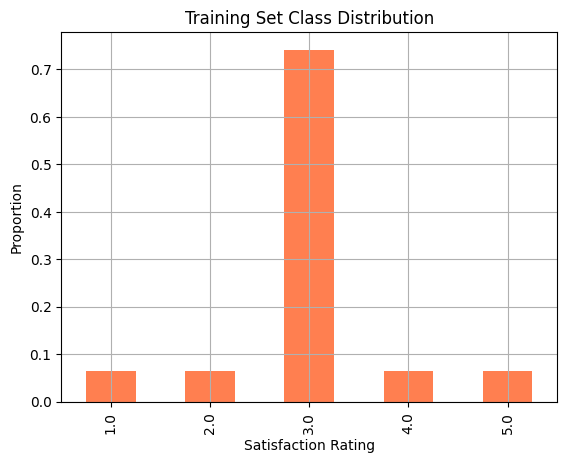

In [ ]:
y_train.value_counts(normalize=True).sort_index().plot(kind='bar', color='coral')
plt.title("Training Set Class Distribution")
plt.xlabel("Satisfaction Rating")
plt.ylabel("Proportion")
plt.grid(True)
plt.show()


#### 8. Model Evaluation

✅ Accuracy: 0.74

📊 Classification Report:
               precision    recall  f1-score   support

         1.0       0.26      0.09      0.13       111
         2.0       0.17      0.05      0.07       110
         3.0       0.78      0.98      0.87      1256
         4.0       0.22      0.04      0.06       108
         5.0       0.11      0.02      0.03       109

    accuracy                           0.74      1694
   macro avg       0.31      0.24      0.23      1694
weighted avg       0.63      0.74      0.66      1694



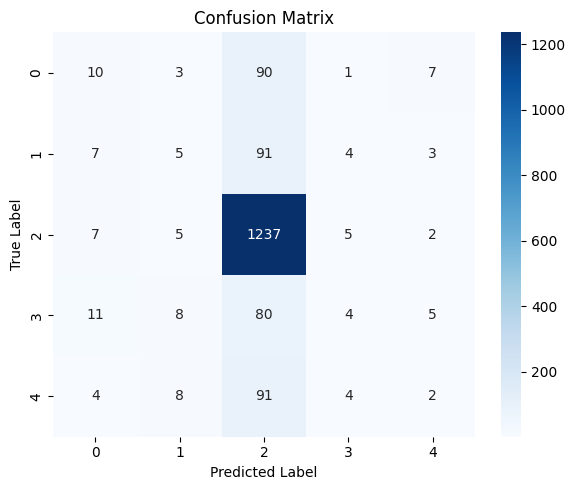

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model performance
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


#### 9. Feature Importance

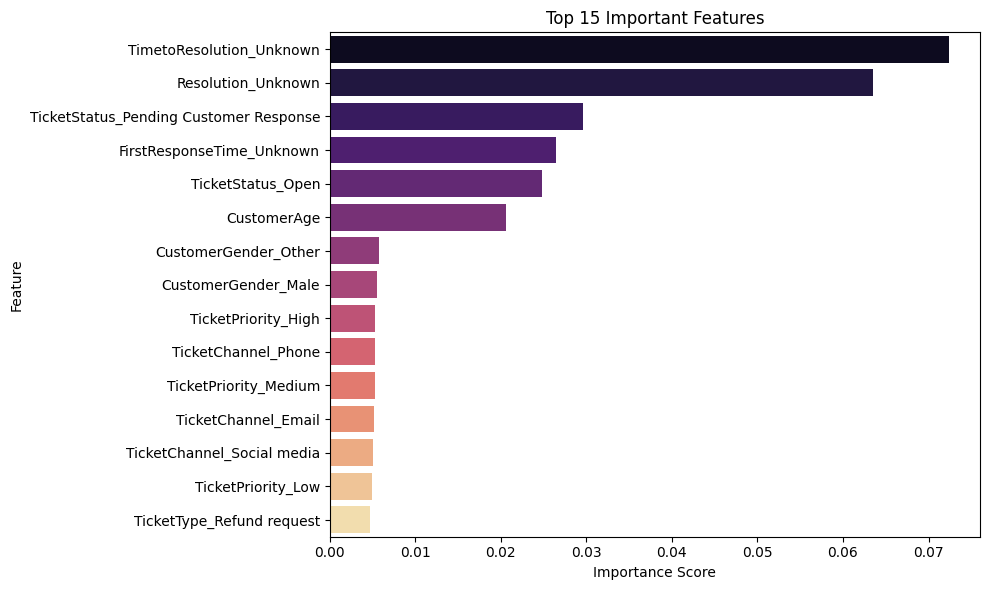

In [ ]:
# Bar Plot - Updated for seaborn >= 0.14 compatibility
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features,
    x='Importance',
    y='Feature',
    hue='Feature',           # Use y-axis variable as hue
    palette='magma',
    dodge=False,             # Prevent side-by-side bars
    legend=False             # No need for a redundant legend
)
plt.title(f"Top {top_n} Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


#### 10. (Optional) Export Model or Predictions

In [ ]:
import joblib
joblib.dump(model, "rf_model.pkl")  # Save model


['rf_model.pkl']

**----------**

## Generate **'eda_summary.xlsx'**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

# Load dataset
df = pd.read_csv('customer_support_tickets.csv')  # Adjust path as needed

# Create Excel writer
with pd.ExcelWriter('eda_summary.xlsx', engine='openpyxl', mode='w') as writer:

    # 1. Overview
    overview = {
        "Total Rows": [df.shape[0]],
        "Total Columns": [df.shape[1]],
        "Missing Values Present": [df.isnull().values.any()],
        "Duplicate Rows": [df.duplicated().sum()],
        "Most Common Ticket Type": [df['TicketType'].mode()[0]] if 'TicketType' in df.columns else ["N/A"],
        "Avg Satisfaction Rating": [round(df['CustomerSatisfactionRating'].mean(), 2)] if 'CustomerSatisfactionRating' in df.columns else ["N/A"]
    }
    pd.DataFrame(overview).T.rename(columns={0: "Value"}).to_excel(writer, sheet_name='01_Overview')

    # 2. Missing Values
    missing = df.isnull().sum().reset_index()
    missing.columns = ['Column Name', 'Missing Count']
    missing['Missing %'] = (missing['Missing Count'] / len(df) * 100).round(2)
    missing = missing[missing['Missing Count'] > 0]
    missing.to_excel(writer, sheet_name='02_Missing_Values', index=False)

    # 3. Categorical Distributions
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        dist = df[col].value_counts().reset_index()
        dist.columns = [col, 'Count']
        sheet_name = f'Dist_{col[:25]}'
        dist.to_excel(writer, sheet_name=sheet_name, index=False)

    # 4. Numerical Statistics
    num_stats = df.describe(include=[np.number]).T
    num_stats = num_stats[['mean', '50%', 'min', 'max', 'std']]
    num_stats.columns = ['Mean', 'Median', 'Min', 'Max', 'Std Dev']
    num_stats.to_excel(writer, sheet_name='03_Numerical_Stats')

    # 5. Correlation Matrix
    corr = df.select_dtypes(include=[np.number]).corr()
    corr.to_excel(writer, sheet_name='04_Correlation_Matrix')

    # 6. Pivot Summary – Avg Satisfaction by Channel
    if {'TicketChannel', 'CustomerSatisfactionRating'}.issubset(df.columns):
        pivot = df.pivot_table(index='TicketChannel', values='CustomerSatisfactionRating', aggfunc='mean').round(2).reset_index()
        pivot.columns = ['TicketChannel', 'Avg Satisfaction']
        pivot.to_excel(writer, sheet_name='05_Satisfaction_By_Channel', index=False)

print("✅ eda_summary.xlsx created successfully!")


✅ eda_summary.xlsx created successfully!


In [ ]:
import numpy as np
np.unique(y_test)


array([1., 2., 3., 4., 5.])

In [ ]:
import os
os.makedirs('reports', exist_ok=True)


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred already exist
cm = confusion_matrix(y_test, y_pred)
labels = [1, 2, 3, 4, 5]  # for 5-class classification
cm_df = pd.DataFrame(cm, index=[f"Actual {i}" for i in labels], columns=[f"Predicted {i}" for i in labels])

# Save to Excel
cm_df.to_excel('reports/confusion_matrix.xlsx')


In [ ]:
from google.colab import files
files.download('reports/confusion_matrix.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('eda_summary.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>